In [1]:
import os
import torch
import uproot
import glob
import torchvision
import numpy as np
from collections import OrderedDict
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
print(uproot.__version__) # Need latest uproot v3.7.1 for LazzyArrays

3.7.2


## A class for load in data from ROOT file, using uproot

It should be generic for all kind of flattree
LazzyArrays is very new for uproot. Need more testing for performances

In [2]:

class P2L1NTP(Dataset):
    def __init__(self, dir_name, features = None,
                 tree_name="l1PhaseIITree/L1PhaseIITree",
                 sequence_length=50, verbose=False):
        self.tree_name = tree_name
        self.features = features
        self.sequence_length = sequence_length
        self.file_names = glob.glob(dir_name)
        ## Cache will be needed in case we train with >1 eposh
        ## Having issue and reported in https://github.com/scikit-hep/uproot/issues/296
        self.cache = uproot.cache.ArrayCache(1024**3)
        self.upTree = uproot.lazyarrays(self.file_names, self.tree_name, self.features.keys(), cache=self.cache)
        #self.upTree = uproot.lazyarrays(self.file_names, self.tree_name, self.features.keys())
        
    def __len__(self):
        return uproot.numentries(self.file_names, self.tree_name, total=True)
    
    def __getitem__(self, idx):
        reflatnp = []
        event = self.upTree[idx]
        for b, ln in self.features.items():
            g  = event[b]
            if isinstance(g,float) == True:
                tg = np.array([g])
            else:
                if len(g)>= ln:
                    tg = g[:ln]
                else:
                    tg = np.pad(g, (0, ln-len(g)), 'constant', constant_values=0)
            reflatnp.append(tg)
        
        org = np.concatenate(reflatnp, axis=0)
        sclpt = org[:12]/40
        scleta = org[12:24]+5
        sclphi = org[24:]+5
        return np.concatenate((sclpt,scleta,sclphi))
        ## If inputs are same length, reshape
        #return np.vstack(reflatnp).reshape((-1,),order='F')
        
        
        
        
        

## Set input files

physics object as a map of variables name in the root file and the expected number of objects.

Class will truncate or pad with 0 to the expected length

In [3]:
bg_files = "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/NeutrinoGun_E_10GeV_V7_5_2_MERGED.root"
sg_files = "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/VBF_HToInvisible_M125_14TeV_pythia8_PU200_V7_4_2.root"
sg_files2 =  "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/VBFHToBB_M-125_14TeV_powheg_pythia8_weightfix_V_7_5_2.root"
sg_files3 = "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/GluGluToHHTo4B_node_SM_14TeV-madgraph_V7_5_2.root"
PhysicsObt = OrderedDict(
    {
    "jetEt" : 12,
    "jetEta" : 12,
    "jetPhi" : 12,
    #"tauEt" : 12,
    #"tauEta" : 12,
    #"tauPhi" : 12,
    #"caloJetEt" : 12,            # this line and below have non-uniform input across array
    #"caloJetEta" : 20,
    #"caloJetPhi" : 20,
    #"globalMuonPt": 1,
    #"globalMuonEta": 1,
    #"globalMuonPhi": 1,
    #"puppiMETEt" : 1,
    #"puppiMETPhi" : 1,
    #"tkCaloJetEt" : 10,
    #"tkCaloJetEta" : 10,
    #"tkCaloJetPhi" : 10,
    #"trackerJetEt" : 10,
    #"trackerJetEta" : 10,
    #"trackerJetPhi" : 10,
    #"tkElectronEt" : 1,
    #"tkElectronEta" : 1,
    #"tkElectronPhi" : 1,
    #"puppiJetEt" : 5,
    #"puppiJetEta" : 5,
    #"puppiJetPhi" : 5,
    #"pfCandEt" : 25,
    #"pfCandEta" : 25,
    #"pfCandPhi" : 25,
    #"tkMuonPt" : 1,
    #"tkMuonEta" : 1,
    #"tkMuonPhi" : 1,
}
)

bg = P2L1NTP(sg_files, PhysicsObt)
gg = bg[0]
print(gg.shape)

# try
file = uproot.open(sg_files3)
#file.keys()
file1 = file['l1PhaseIITree']
file2=file1['L1PhaseIITree']
file3 = file2['jetEt'].array()

#(271,499100,eg.12(some are diff))
#271 physobj/para > coming from 1 of the 499100 events > 12 particles     


(36,)


In [20]:
import time
start = time.time()
num_epochs = 10
batch_size = 150 #144
learning_rate = 1e-3
features = 36
dataloader = DataLoader(bg, batch_size=batch_size, pin_memory=True, shuffle=False)



class autoencoder(nn.Module):
    def __init__(self,features):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(features, int(features*2/3)),#144,1280
            nn.ReLU(True),
            nn.Linear(int(features*2/3), int(features/3)), # 1280,64
            #nn.ReLU(True), 
            #nn.Linear(64, 12), #64,12
            #nn.ReLU(True), 
            #nn.Linear(int(features/3), int(features/6)),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            #nn.Linear(int(features/6), int(features/3)),
            #nn.ReLU(True),
            nn.Linear(int(features/3), int(features*2/3)),
            nn.ReLU(True),
            #nn.Linear(64, 98),
            #nn.ReLU(True), 
            nn.Linear(int(features*2/3), features), 
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = autoencoder(features)

if torch.cuda.is_available():
    model = model.cuda()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    #model.parameters(), lr=0.001, rho=0.9, epsilon=None, decay=1e-5)
    #(model.parameters(), lr=learning_rate, weight_decay=1e-5)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )    


train_frac = 0.2
for epoch in range(num_epochs):
    val_loss = []

    for batch_idx, bg_data in enumerate(dataloader):
        _bg_img = Variable(bg_data.type(torch.FloatTensor))
        
        if torch.cuda.is_available():
            _bg_img = _bg_img.cuda()
        if batch_idx < (len(dataloader)*0.8):
            # ===================forward=====================
            out = model(_bg_img)
            loss = criterion(out, _bg_img)
            # ===================backward====================
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            # =================validation===================
        else:
            
            val_out = model(_bg_img)
            _val_loss = criterion(val_out, _bg_img)
            _val_loss = _val_loss.cpu().detach().numpy()
            val_loss.append(_val_loss)
        
        
        # ===================log========================
    
    print('epoch [{}/{}], loss:{:.4f}, val loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0], val_loss[0]))
    scheduler.step(loss)
    

torch.save(model.state_dict(), './sim_autoencoder.pth')

#torch.onnx.export(model, "sim_autoencoder.onnx", verbose=True, export_params=True)

end=time.time()
print('{} mins'.format((end-start)/60))


/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/envs/mlenv0/lib/python3.6/site-packages/ipykernel_launcher.py:89: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/10], loss:2.2046, val loss:2.1714
epoch [2/10], loss:1.8342, val loss:1.8526
epoch [3/10], loss:1.6905, val loss:1.7222
epoch [4/10], loss:1.5960, val loss:1.6232
epoch [5/10], loss:1.5203, val loss:1.5296
epoch [6/10], loss:1.3951, val loss:1.4131
epoch [7/10], loss:1.2781, val loss:1.2954
epoch [8/10], loss:1.2410, val loss:1.2434
epoch [9/10], loss:1.2213, val loss:1.2138
epoch [10/10], loss:1.2040, val loss:1.1912
3.1738879402478535 mins


In [21]:

dataloader = DataLoader(bg, batch_size=batch_size, pin_memory=True, shuffle=False)

for batch_idx, vbg_data in enumerate(dataloader):
    _vbg_img = Variable(vbg_data.type(torch.FloatTensor))
    if torch.cuda.is_available():
        _vbg_img = _vbg_img.cuda()
        
    vout = model(_vbg_img)
    p_vout = vout[:,:12]
    a_vout = vout[:,12:]
    p_vloss = criterion(p_vout,_vbg_img[:,:12])
    a_vloss = criterion(a_vout, _vbg_img[:,12:])
    vloss = criterion(vout, _vbg_img)
    vbg_data = vbg_data.numpy()
    _vbg_out = vout.cpu().detach().numpy()
    _p_vbg_loss = p_vloss.cpu().detach().numpy()
    _a_vbg_loss = a_vloss.cpu().detach().numpy()
    _vbg_loss = vloss.cpu().detach().numpy()
    if batch_idx == 0:
        vbg_out = _vbg_out
        p_vbg_loss = _p_vbg_loss
        a_vbg_loss = _a_vbg_loss
        vbg_loss = _vbg_loss
        vbg_img = vbg_data
            
    else:
        p_vbg_loss = np.append([p_vbg_loss],[_p_vbg_loss])
        a_vbg_loss = np.append([a_vbg_loss],[_a_vbg_loss])
        vbg_loss = np.append([vbg_loss],[_vbg_loss])
        vbg_out = np.concatenate((vbg_out,_vbg_out))
        vbg_img = np.concatenate((vbg_img,vbg_data))
    
print(p_vbg_loss.shape, a_vbg_loss.shape, vbg_loss.shape)

(285,) (285,) (285,)


In [22]:
#Scaling back


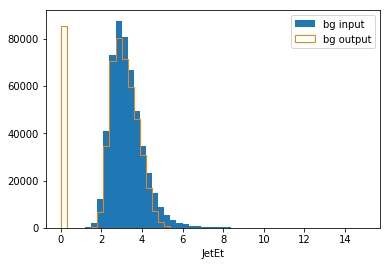

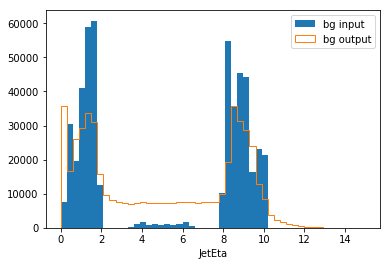

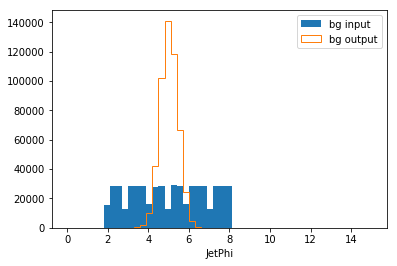

In [23]:
import matplotlib.pyplot as plt

plt.hist((vbg_img[:,0:12]).flatten(), bins=50, range=(0,15), label='bg input')
plt.hist((vbg_out[:,0:12]).flatten(), histtype='step',bins=50,range=(0,15),label='bg output')
plt.legend(loc='best')
plt.xlabel('JetEt')
plt.show()

plt.hist((vbg_img[:,12:24]).flatten(), bins=50, range=(0,15), label='bg input')
plt.hist((vbg_out[:,12:24]).flatten(), histtype='step',bins=50,range=(0,15),label='bg output')
plt.legend(loc='best')
plt.xlabel('JetEta')
plt.show()

plt.hist((vbg_img[:,24:]).flatten(), bins=50, range=(0,15), label='bg input')
plt.hist((vbg_out[:,24:]).flatten(), histtype='step',bins=50,range=(0,15),label='bg output')
plt.legend(loc='best')
plt.xlabel('JetPhi')
plt.show()

## Testing cells below



In [24]:
#batch no.=1336
# data size = 499100 events, 3*10+2*1=32 per event
#1336th (idx=1335) countains (16,32) array
#total = 42736

In [25]:
# H to Invisible
new_batch_size = 300
sg = P2L1NTP(sg_files, PhysicsObt)
sg_dataloader = DataLoader(sg, batch_size=new_batch_size, pin_memory=True, shuffle=False)

model = autoencoder(features)
for batch_idx, sg_data in enumerate(sg_dataloader):
    
    _sg_img = Variable(sg_data.type(torch.FloatTensor))
    _sg_out = model(_sg_img)
    p_sg_out = _sg_out[:,:12]
    a_sg_out = _sg_out[:,12:]
    _p_sg_loss = criterion(p_sg_out, _sg_img[:,:12])
    _a_sg_loss = criterion(a_sg_out, _sg_img[:,12:])
    _sg_loss = criterion (_sg_out, _sg_img)
    sg_data = sg_data.numpy()
    _sg_out = _sg_out.detach().numpy()
    _p_sg_loss = _p_sg_loss.detach().numpy()
    _a_sg_loss = _a_sg_loss.detach().numpy()
    _sg_loss = _sg_loss.detach().numpy()
    if batch_idx == 0:
        sg_out = _sg_out
        p_sg_loss = _p_sg_loss
        a_sg_loss = _a_sg_loss
        sg_loss = _sg_loss
        sg_img = sg_data
    
    else:
        p_sg_loss = np.append([p_sg_loss],[_p_sg_loss])
        a_sg_loss = np.append([a_sg_loss],[_a_sg_loss])
        sg_loss = np.append([sg_loss],[_sg_loss]) 
        sg_out = np.concatenate((sg_out,_sg_out))
        sg_img = np.concatenate((sg_img,sg_data))
    

print(p_sg_loss.shape,a_sg_loss.shape,sg_loss.shape)

    

(143,) (143,) (143,)


In [26]:
# VBFH to BB
new_batch_size = 300
sg2 = P2L1NTP(sg_files2, PhysicsObt)
sg2_dataloader = DataLoader(sg2, batch_size=new_batch_size, pin_memory=True, shuffle=False)

model = autoencoder(features)
for batch_idx, sg2_data in enumerate(sg2_dataloader):
    
    _sg2_img = Variable(sg2_data.type(torch.FloatTensor))
    
    _sg2_out = model(_sg2_img)
    p_sg2_out = _sg2_out[:,:12]
    a_sg2_out = _sg2_out[:,12:]
    _p_sg2_loss = criterion(p_sg2_out, _sg2_img[:,:12])
    _a_sg2_loss = criterion(a_sg2_out, _sg2_img[:,12:])
    _sg2_loss = criterion(_sg2_out, _sg2_img)
    sg2_data = sg2_data.numpy()
    _sg2_out = _sg2_out.detach().numpy()
    _p_sg2_loss = _p_sg2_loss.detach().numpy()
    _a_sg2_loss = _a_sg2_loss.detach().numpy()
    _sg2_loss = _sg2_loss.detach().numpy()
    if batch_idx == 0:
        sg2_out = _sg2_out
        p_sg2_loss = _p_sg2_loss
        a_sg2_loss = _a_sg2_loss
        sg2_loss = _sg2_loss
        sg2_img = sg2_data
    
    else:
        p_sg2_loss = np.append([p_sg2_loss],[_p_sg2_loss])
        a_sg2_loss = np.append([a_sg2_loss],[_a_sg2_loss])
        sg2_loss = np.append([sg2_loss],[_sg2_loss])
        sg2_out = np.concatenate((sg2_out,_sg2_out))
        sg2_img = np.concatenate((sg2_img,sg2_data))
    

print(p_sg2_loss.shape,a_sg2_loss.shape, sg2_loss.shape)

(290,) (290,) (290,)


In [27]:
# GluGlu to HH to 4B
new_batch_size = 300
sg3 = P2L1NTP(sg_files3, PhysicsObt)
sg3_dataloader = DataLoader(sg3, batch_size=new_batch_size, pin_memory=True, shuffle=False)

model = autoencoder(features)
for batch_idx, sg3_data in enumerate(sg3_dataloader):
    
    _sg3_img = Variable(sg3_data.type(torch.FloatTensor))
    _sg3_out = model(_sg3_img)
    p_sg3_out = _sg3_out[:,:12]
    a_sg3_out = _sg3_out[:,12:]
    _p_sg3_loss = criterion(p_sg3_out, _sg3_img[:,:12])
    _a_sg3_loss = criterion(a_sg3_out, _sg3_img[:,12:])
    _sg3_loss = criterion(_sg3_out, _sg3_img)
    sg3_data = sg3_data.numpy()
    _sg3_out = _sg3_out.detach().numpy()
    _p_sg3_loss = _p_sg3_loss.detach().numpy()
    _a_sg3_loss = _a_sg3_loss.detach().numpy()
    _sg3_loss = _sg3_loss.detach().numpy()
    if batch_idx == 0:
        sg3_out = _sg3_out
        p_sg3_loss = _p_sg3_loss
        a_sg3_loss = _a_sg3_loss
        sg3_loss = _sg3_loss
        sg3_img = sg3_data
    
    else:
        p_sg3_loss = np.append([p_sg3_loss],[_p_sg3_loss])
        a_sg3_loss = np.append([a_sg3_loss],[_a_sg3_loss])
        sg3_loss = np.append([sg3_loss],[_sg3_loss])
        sg3_out = np.concatenate((sg3_out,_sg3_out))
        sg3_img = np.concatenate((sg3_img,sg3_data))
    

print(p_sg3_loss.shape,a_sg3_loss.shape, sg3_loss.shape)

(326,) (326,) (326,)


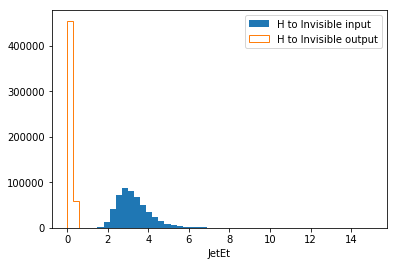

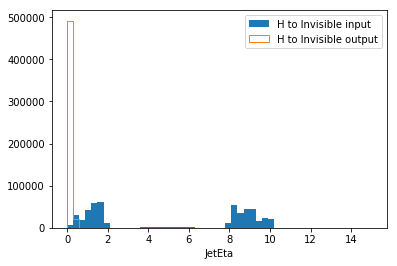

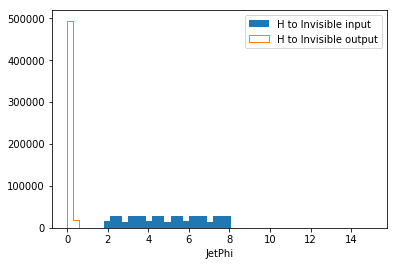

In [28]:
plt.hist((sg_img[:,0:12]).flatten(), bins=50, range=(0,15), label='H to Invisible input')
plt.hist((sg_out[:,0:12]).flatten(), histtype='step',bins=50,range=(0,15),label='H to Invisible output')
plt.legend(loc='best')
plt.xlabel('JetEt')
plt.show()

plt.hist((sg_img[:,12:24]).flatten(), bins=50, range=(0,15), label='H to Invisible input')
plt.hist((sg_out[:,12:24]).flatten(), histtype='step',bins=50,range=(0,15),label='H to Invisible output')
plt.legend(loc='best')
plt.xlabel('JetEta')
plt.show()

plt.hist((sg_img[:,24:]).flatten(), bins=50, range=(0,15), label='H to Invisible input')
plt.hist((sg_out[:,24:]).flatten(), histtype='step',bins=50,range=(0,15),label='H to Invisible output')
plt.legend(loc='best')
plt.xlabel('JetPhi')
plt.show()

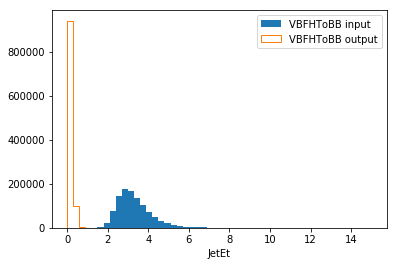

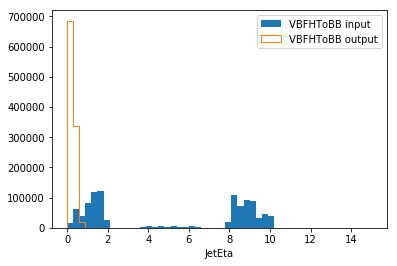

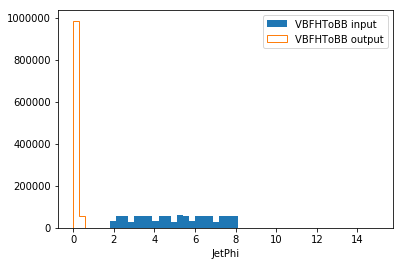

In [29]:
plt.hist((sg2_img[:,0:12]).flatten(), bins=50, range=(0,15), label='VBFHToBB input')
plt.hist((sg2_out[:,0:12]).flatten(), histtype='step',bins=50,range=(0,15),label='VBFHToBB output')
plt.legend(loc='best')
plt.xlabel('JetEt')
plt.show()

plt.hist((sg2_img[:,12:24]).flatten(), bins=50, range=(0,15), label='VBFHToBB input')
plt.hist((sg2_out[:,12:24]).flatten(), histtype='step',bins=50,range=(0,15),label='VBFHToBB output')
plt.legend(loc='best')
plt.xlabel('JetEta')
plt.show()

plt.hist((sg2_img[:,24:]).flatten(), bins=50, range=(0,15), label='VBFHToBB input')
plt.hist((sg2_out[:,24:]).flatten(), histtype='step',bins=50,range=(0,15),label='VBFHToBB output')
plt.legend(loc='best')
plt.xlabel('JetPhi')
plt.show()

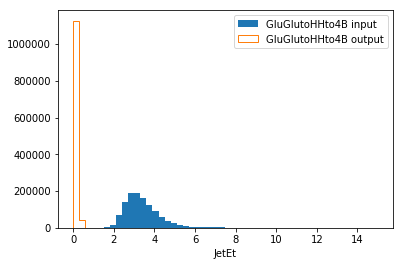

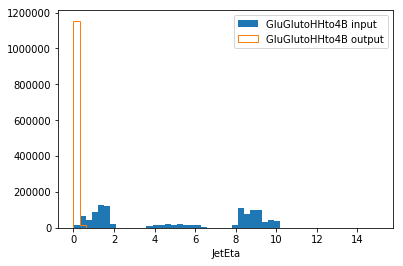

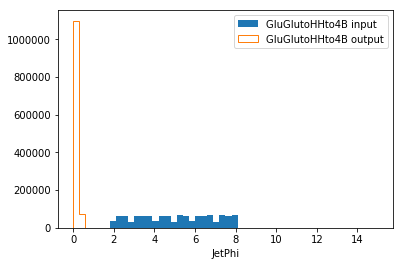

In [30]:
plt.hist((sg3_img[:,0:12]).flatten(), bins=50, range=(0,15), label='GluGlutoHHto4B input')
plt.hist((sg3_out[:,0:12]).flatten(), histtype='step',bins=50,range=(0,15),label='GluGlutoHHto4B output')
plt.legend(loc='best')
plt.xlabel('JetEt')
plt.show()

plt.hist((sg3_img[:,12:24]).flatten(), bins=50, range=(0,15), label='GluGlutoHHto4B input')
plt.hist((sg3_out[:,12:24]).flatten(), histtype='step',bins=50,range=(0,15),label='GluGlutoHHto4B output')
plt.legend(loc='best')
plt.xlabel('JetEta')
plt.show()

plt.hist((sg3_img[:,24:]).flatten(), bins=50, range=(0,15), label='GluGlutoHHto4B input')
plt.hist((sg3_out[:,24:]).flatten(), histtype='step',bins=50,range=(0,15),label='GluGlutoHHto4B output')
plt.legend(loc='best')
plt.xlabel('JetPhi')
plt.show()

3.2894726 3.312562 3.4845884


Text(0.5, 0, 'Reconstruction Loss')

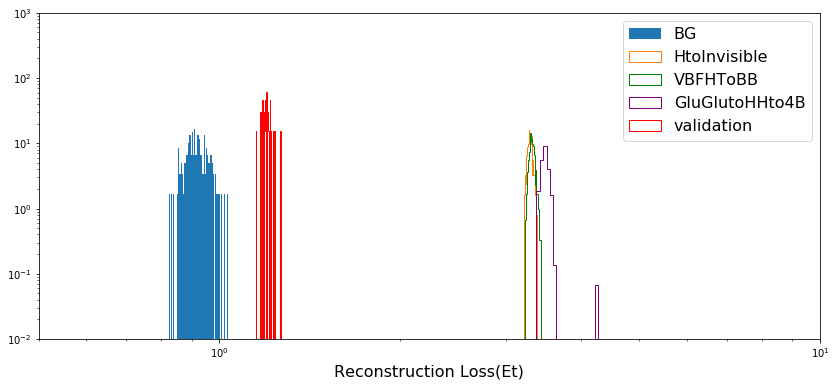

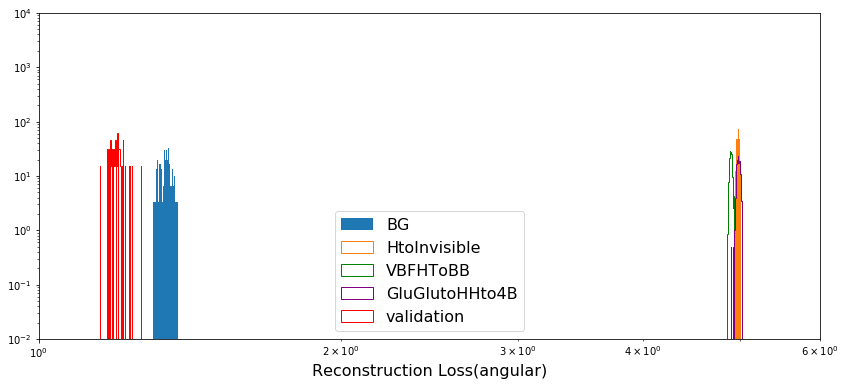

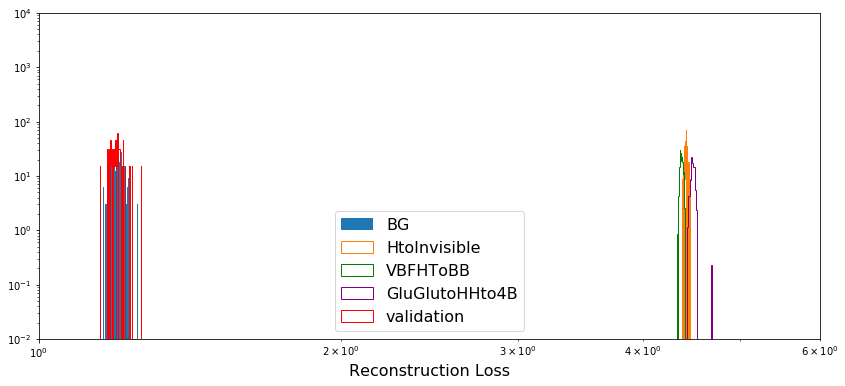

In [35]:
plt.figure(figsize=(14,6))
plt.hist(p_vbg_loss,bins=100,label='BG', normed=True)
plt.hist(p_sg_loss,bins=20,label='HtoInvisible', histtype='step', normed=True)
plt.hist(p_sg2_loss,bins=20,label='VBFHToBB', histtype='step',color='green', normed=True)
plt.hist(p_sg3_loss,bins=20,label='GluGlutoHHto4B', histtype='step',color='purple', normed=True)
plt.hist(val_loss,bins=100,label='validation',histtype="step",color='red', normed=True)
plt.legend(loc='best',fontsize=16)
plt.ylim(1e-2,1e3)
plt.xlim(0.5,10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Reconstruction Loss(Et)', fontsize=16)
print(np.mean(p_sg_loss),np.mean(p_sg2_loss),np.mean(p_sg3_loss))

plt.figure(figsize=(14,6))
plt.hist(a_vbg_loss,bins=100,label='BG', normed=True)
plt.hist(a_sg_loss,bins=100,label='HtoInvisible', histtype='step', normed=True)
plt.hist(a_sg2_loss,bins=20,label='VBFHToBB', histtype='step',color='green', normed=True)
plt.hist(a_sg3_loss,bins=20,label='GluGlutoHHto4B', histtype='step',color='purple', normed=True)
plt.hist(val_loss,bins=100,label='validation',histtype="step",color='red', normed=True)
plt.legend(loc='best',fontsize=16)
plt.ylim(1e-2,1e4)
plt.xlim(1,6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Reconstruction Loss(angular)', fontsize=16)

plt.figure(figsize=(14,6))
plt.hist(vbg_loss,bins=100,label='BG', normed=True)
plt.hist(sg_loss,bins=100,label='HtoInvisible', histtype='step', normed=True)
plt.hist(sg2_loss,bins=20,label='VBFHToBB', histtype='step',color='green', normed=True)
plt.hist(sg3_loss,bins=20,label='GluGlutoHHto4B', histtype='step',color='purple', normed=True)
plt.hist(val_loss,bins=100,label='validation',histtype="step",color='red', normed=True)
plt.legend(loc='best',fontsize=16)
plt.ylim(1e-2,1e4)
plt.xlim(1,6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Reconstruction Loss', fontsize=16)

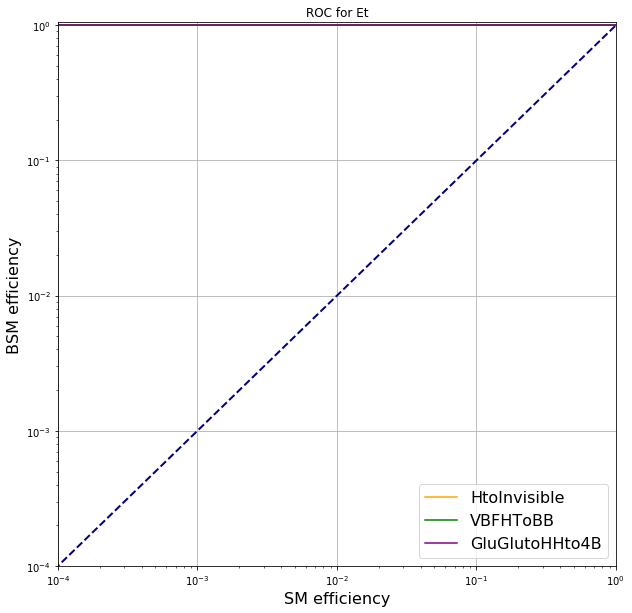

In [19]:
p_SM = np.logspace(base=10, start=-5, stop=0, num=100)
p_SM[-1] = 0.999

f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax_arr_ROC.set_xlim([1e-4, 1])
ax_arr_ROC.set_ylim([1e-4, 1.05])
ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
ax_arr_ROC.ticklabel_format()
ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
ax_arr_ROC.set_yscale('log')
ax_arr_ROC.set_xscale('log')
ax_arr_ROC.set_title('ROC for Et')
ax_arr_ROC.grid()

p_bg_sort = np.argsort(p_vbg_loss)
p_bg_re_loss = p_vbg_loss[p_bg_sort]

# Find out the sm threshold values corresponding to each percentile in p_SM
frac = np.cumsum(np.ones_like(p_bg_re_loss)/len(p_bg_re_loss)) # an array of fraction (1/n, 2/n, etc.)

indices_of_thresholds = np.argmax(frac > np.atleast_2d(1-p_SM).T, axis=1) # which element closest to each value in p_SM
p_bg_thresholds = p_bg_re_loss[indices_of_thresholds] # what are the corresponding threshold values


p_sg_frac = np.float64(np.sum(p_sg_loss > np.atleast_2d(p_bg_thresholds).T, axis=1, dtype=np.float128)/len(p_sg_loss))

p_sg2_frac = np.float64(np.sum(p_sg2_loss > np.atleast_2d(p_bg_thresholds).T, axis=1, dtype=np.float128)/len(p_sg2_loss))

p_sg3_frac = np.float64(np.sum(p_sg3_loss > np.atleast_2d(p_bg_thresholds).T, axis=1, dtype=np.float128)/len(p_sg3_loss))

ax_arr_ROC.plot(p_SM,p_sg_frac,label='HtoInvisible', color='orange')
ax_arr_ROC.plot(p_SM,p_sg2_frac,label='VBFHToBB',color='green')
ax_arr_ROC.plot(p_SM,p_sg3_frac,label='GluGlutoHHto4B',color='purple')


ax_arr_ROC.legend(loc="lower right", fontsize=16)




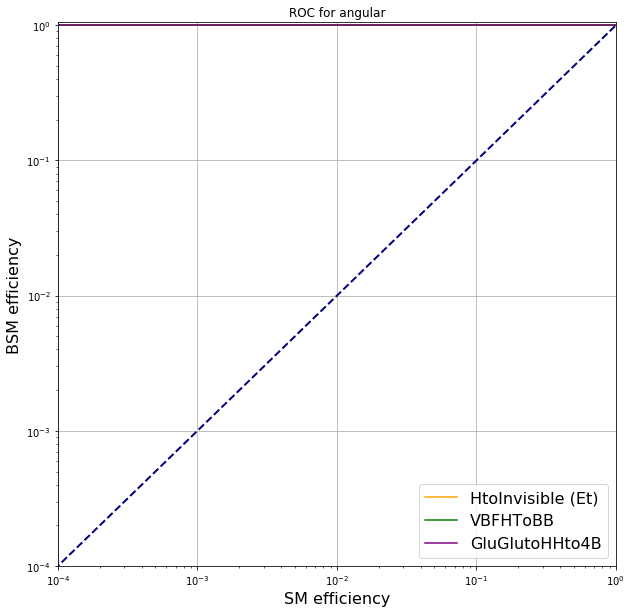

In [27]:
f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax_arr_ROC.set_xlim([1e-4, 1])
ax_arr_ROC.set_ylim([1e-4, 1.05])
ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
ax_arr_ROC.ticklabel_format()
ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
ax_arr_ROC.set_yscale('log')
ax_arr_ROC.set_xscale('log')
ax_arr_ROC.set_title('ROC for angular')
ax_arr_ROC.grid()


a_bg_sort = np.argsort(a_vbg_loss)
a_bg_re_loss = a_vbg_loss[a_bg_sort]

a_frac = np.cumsum(np.ones_like(a_bg_re_loss)/len(a_bg_re_loss))
a_indices_of_thresholds = np.argmax(a_frac > np.atleast_2d(1-p_SM).T, axis=1) 

a_bg_thresholds = a_bg_re_loss[a_indices_of_thresholds]

a_sg_frac = np.float64(np.sum(a_sg_loss > np.atleast_2d(a_bg_thresholds).T, axis=1, dtype=np.float128)/len(a_sg_loss))

a_sg2_frac = np.float64(np.sum(a_sg2_loss > np.atleast_2d(a_bg_thresholds).T, axis=1, dtype=np.float128)/len(a_sg2_loss))

a_sg3_frac = np.float64(np.sum(a_sg3_loss > np.atleast_2d(a_bg_thresholds).T, axis=1, dtype=np.float128)/len(a_sg3_loss))

ax_arr_ROC.plot(p_SM,a_sg_frac,label='HtoInvisible (Et)',color='orange')
ax_arr_ROC.plot(p_SM,a_sg2_frac,label='VBFHToBB',color='green')
ax_arr_ROC.plot(p_SM,a_sg3_frac,label='GluGlutoHHto4B',color='purple')


ax_arr_ROC.legend(loc="lower right", fontsize=16)

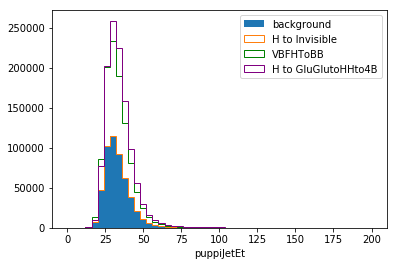

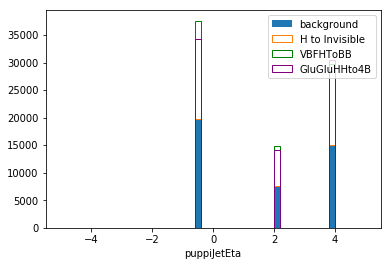

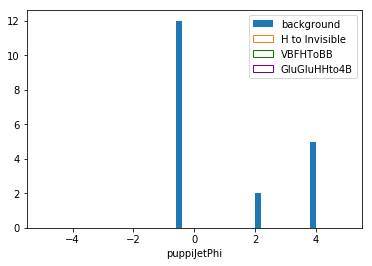

In [22]:
plt.hist((vbg_img[:,0:12]*10).flatten(), bins=50, range=(0,200), label='background')
plt.hist((sg_img[:,0:12]*10).flatten(), histtype='step',bins=50,range=(0,200),label='H to Invisible')
plt.hist((sg2_img[:,0:12]*10).flatten(), histtype='step',color='green',bins=50,range=(0,200),label='VBFHToBB')
plt.hist((sg3_img[:,0:12]*10).flatten(), histtype='step',color='purple',bins=50,range=(0,200),label='H to GluGlutoHHto4B')
plt.legend(loc='best')
plt.xlabel('puppiJetEt')
plt.show()

plt.hist((vbg_img[:,12:24]*10).flatten(), bins=50, range=(-5,5), label='background')
plt.hist((sg_img[:,12:24]*10).flatten(), histtype='step',bins=50,range=(-5,5),label='H to Invisible')
plt.hist((sg2_img[:,12:24]*10).flatten(), histtype='step',color='green',bins=50,range=(-5,5),label='VBFHToBB')
plt.hist((sg3_img[:,12:24]*10).flatten(), histtype='step',color='purple',bins=50,range=(-5,5),label='GluGluHHto4B')
plt.legend(loc='best')
plt.xlabel('puppiJetEta')
plt.show()

plt.hist((vbg_img[:24:]*10).flatten(), bins=50, range=(-5,5), label='background')
plt.hist((sg_img[:,24:]*10).flatten(), histtype='step',bins=50,range=(-5,5),label='H to Invisible')
plt.hist((sg2_img[:,24:]*10).flatten(), histtype='step',color='green',bins=50,range=(-5,5),label='VBFHToBB')
plt.hist((sg3_img[:,24:]*10).flatten(), histtype='step',color='purple',bins=50,range=(-5,5),label='GluGluHHto4B')
plt.legend(loc='best')
plt.legend(loc='best')
plt.xlabel('puppiJetPhi')
plt.show()

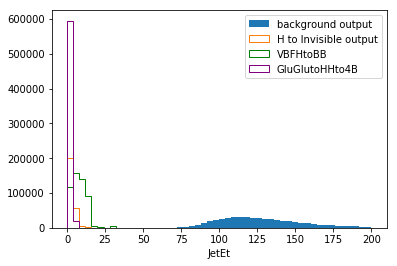

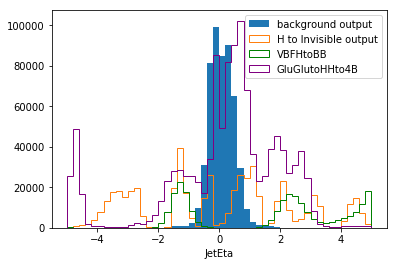

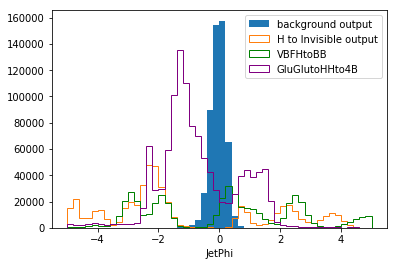

In [29]:
plt.hist((vbg_out[:,0:12]*10).flatten(), bins=50, range=(0,200), label='background output')
plt.hist((sg_out[:,0:12]*10).flatten(), histtype='step',bins=50,range=(0,200),label='H to Invisible output')
plt.hist((sg2_out[:,0:12]*10).flatten(), histtype='step',color='green',bins=50,range=(0,200),label='VBFHtoBB')
plt.hist((sg3_out[:,0:12]*10).flatten(), histtype='step',color='purple',bins=50,range=(0,200),label='GluGlutoHHto4B')
plt.legend(loc='best')
plt.xlabel('JetEt')
plt.show()

plt.hist((vbg_out[:,12:24]*10).flatten(), bins=50, range=(-5,5), label='background output')
plt.hist((sg_out[:,12:24]*10).flatten(), histtype='step',bins=50,range=(-5,5),label='H to Invisible output')
plt.hist((sg2_out[:,12:24]*10).flatten(), histtype='step',color='green',bins=50,range=(-5,5),label='VBFHtoBB')
plt.hist((sg3_out[:,12:24]*10).flatten(), histtype='step',color='purple',bins=50,range=(-5,5),label='GluGlutoHHto4B')
plt.legend(loc='best')
plt.xlabel('JetEta')
plt.show()

plt.hist((vbg_out[:,24:]*10).flatten(), bins=50, range=(-5,5), label='background output')
plt.hist((sg_out[:,24:]*10).flatten(), histtype='step',bins=50,range=(-5,5),label='H to Invisible output')
plt.hist((sg2_out[:,24:]*10).flatten(), histtype='step',color='green',bins=50,range=(-5,5),label='VBFHtoBB')
plt.hist((sg3_out[:,24:]*10).flatten(), histtype='step',color='purple',bins=50,range=(-5,5),label='GluGlutoHHto4B')
plt.legend(loc='best')
plt.xlabel('JetPhi')
plt.show()

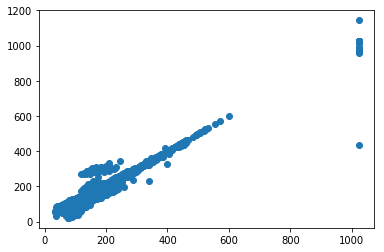

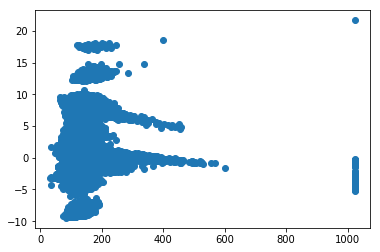

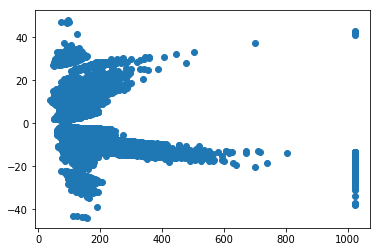

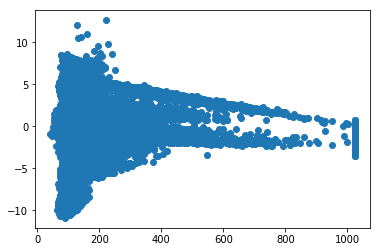

In [31]:
# 2D scatter plot for eta
x = (vbg_img[:,:12]*10).flatten()
y = (vbg_out[:,:12]*10).flatten()
plt.scatter(x,y)
plt.show()

sx = (sg_img[:,:12]*10).flatten()
sy = (sg_out[:,:12]*10).flatten()
plt.scatter(sx,sy)
plt.show()

sx2 = (sg2_img[:,:12]*10).flatten()
sy2 = (sg2_out[:,:12]*10).flatten()
plt.scatter(sx2,sy2)
plt.show()

sx3 = (sg3_img[:,:12]*10).flatten()
sy3 = (sg3_out[:,:12]*10).flatten()
plt.scatter(sx3,sy3)
plt.show()

In [6]:
bg_files = "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/NeutrinoGun_E_10GeV_V7_5_2_MERGED.root"
nocache_data = uproot.lazyarrays(bg_files, "l1PhaseIITree/L1PhaseIITree", PhysicsObt.keys(), entrysteps=100)
cache = uproot.cache.ArrayCache(1024**3)
data = uproot.lazyarrays(bg_files, "l1PhaseIITree/L1PhaseIITree",PhysicsObt.keys(), entrysteps=100,cache=cache)/200

print(len(data['caloJetEt'][0]))

20


### In case you don't have uproot, you can use my local copy in LPC

Or, just "pip3 install uproot"

In [ ]:
import sys
sys.path.insert(0, "/uscms/home/benwu/.local/lib/python3.6/site-packages/")
print(sys.path)

In [10]:
# Shuffle by indexing instead of copies. 
def random_dataloaders(dataset, train_frac, valid_frac, batch_size):
    # Split training into train and validation
    indices = torch.randperm(len(dataset))
    train_indices = indices[:len(indices)*valid_frac]
    valid_indices = indices[len(indices)*valid_frac:]

    train_loader = torch.utils.data.DataLoader(train_set, pin_memory=True, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(train_indices))
    valid_loader = torch.utils.data.DataLoader(valid_set, pin_memory=True, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(valid_indices))

    return train_loader, valid_loader

In [ ]:
# try
#new_batch_size = batch_size * 10
#sg_loader = DataLoader(bg, batch_size=new_batch_size, pin_memory=True, shuffle=False)

#for batch, idx in enumerate(sg_loader):
    #x = 